<a href="https://colab.research.google.com/github/dcastf01/adversarial_project/blob/main/Create_adversarial_images_with_differents_models_at_same_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduccion

Notebook para la creación de imágenes adversariales para un estudio que se está realizando en el Vrain

Es útil usar el siguiente video para la creación de nuestras imagenes adversariales

El modelo que se va a utilizar es el Nasnet

In [1]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
  
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  #strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
  strategy=tf.distribute.OneDeviceStrategy(gpus[0])
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Tensorflow version 2.4.1
Running on CPU
Number of accelerators:  1


In [2]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                print(chunk)
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"
   #URL=" https://docs.google.com/open?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

In [4]:
%%capture
set_image_to_create_adversarial=True  #@param {type:"boolean"} 

if set_image_to_create_adversarial:
  file_id="1QA2HeOxusHicdbUxg54M8PG2GorB8ukG"
  destination="ILSVRC2012_val_5.zip"
  download_file_from_google_drive(file_id, destination)


label_id="1PKH4QWZe_VCOhu19oOhbV9z-YKrKACO7"
destination_label_id="/content/label.txt"
download_file_from_google_drive(label_id, destination_label_id)

label_real_name="1sxe3eunq5U4EwsHlLaeRmwcnaZjCEcnh"
destination_label_real_name="/content/name_real_label.json"
download_file_from_google_drive(label_real_name, destination_label_real_name)

In [5]:
%%capture 
!mkdir data
!unzip /content/ILSVRC2012_val_5.zip  -d data

#Define labels

In [6]:
import json
relation_classid_classname="/content/name_real_label.json"
relation_file_classid="/content/label.txt"
def get_dictionary_with_real_class():
  path_json_real_label=relation_classid_classname #el json es el bueno
  real_class_prev=json.loads(open(path_json_real_label).read())
  real_class=dict()
  for k in real_class_prev:
    real_class[int(k)]=real_class_prev[k][1] #dictionary key:number value:string
  return real_class


def get_all_labels(file_path_map):

  #file_path_map="/content/ILSVRC2012_validation_map_real.txt"
  conjunto_name_and_label = [l.strip() for l in open(file_path_map).readlines()]
  names=list()
  labels=list()
  for conjunto in conjunto_name_and_label:
    names_and_labels=conjunto.split(" ")
    names.append(names_and_labels[0])
    labels.append(names_and_labels[1])
  return dict(zip(names, labels))

def get_idclass_from_filename(filename):
  return int(dictionary_filename_idclass[filename])
def get_nameclass_from_idclass(idclass):
  return dictionary_idclass_nameclass[int(idclass)]


In [7]:

dictionary_filename_idclass=get_all_labels(relation_file_classid)
dictionary_idclass_nameclass=get_dictionary_with_real_class()

#Create model

Requisito, ambos modelos deben de tener el  mismo tamaño de entrada

In [8]:
#@title class model necessary to wrap all
class Model:
  def __init__(self,model,result_target:float):
    self.model=model
    self.model_name=model.name
    self.result_target=result_target
    self.type_result=self.get_type_result()

    self.model_predicts_the_correct_class=None
    self.accuracy_in_the_class_of_this_image=None
    self.threshold_target_accuracy_in_the_class_of_this_image=None
    self.is_necessary_continue_modified_because_the_image_target_not_achieve=None
    # self.calculate_loss=True

  def get_type_result(self):
    if self.result_target==1:
      return "improving model 100% accuracy"
    elif self.result_target==0:
      return "The model always fail"
    else:
      return "The model is random with a accuracy of {} % ".format(self.result_target*100)
    
  def is_next_iteracion_model_predicts_the_correct_class(self):
      random_number=tf.random.uniform(
            [], minval=0.000001, maxval=1, dtype=tf.dtypes.float32, seed=None, name=None
            )
      if self.result_target-random_number>=0: 

        self.model_predicts_the_correct_class=True
        self.accuracy_in_the_class_of_this_image=0
        self.threshold_target_accuracy_in_the_class_of_this_image=0.95

      else:

        self.model_predicts_the_correct_class=False
        self.accuracy_in_the_class_of_this_image=1
        self.threshold_target_accuracy_in_the_class_of_this_image=0.01

  def predict(self,image):
    self.prediction=self.model(image,training=False)

  def update_accuracy_in_the_class_of_this_image(self,target_class):
    self.accuracy_in_the_class_of_this_image=self.prediction[0][target_class].numpy()
  # def continue_calculate_loss(self):

  #   if self.model_predicts_the_correct_class and self.accuracy_in_the_class_of_this_image<self.threshold_target_accuracy_in_the_class_of_this_image:
  #       self.calculate_loss=True

  #   elif  not self.model_predicts_the_correct_class and self.accuracy_in_the_class_of_this_image>self.threshold_target_accuracy_in_the_class_of_this_image:
  #       self.calculate_loss=True

  #   else:
  #       self.calculate_loss=False
      


In [9]:
#@title check how many models have the same size
def clean_list_of_models_names(lists_of_private_object):
  #todos los modelos empiezan por mayuscula y no son privados, es decir no pueden empezar con "_"
  prev_clean_list=list()
  clean_list=list()
  for element in lists_of_private_object:
    if element[0]=="_" or not element[0].isupper():
      pass
    else:
      
      prev_clean_list.append(element)
  return prev_clean_list
IMG_WIDTH_TEMPLATE=224#@param {type:"integer"}
IMG_HEIGHT_TEMPLATE=224#@param {type:"integer"}

all_models_in_keras_without_clean=dir(tf.keras.applications)
ALL_MODELS=clean_list_of_models_names(all_models_in_keras_without_clean)
names_models_to_use=[]
for model_name in ALL_MODELS:
  model=model=getattr(tf.keras.applications,model_name)(include_top=True, weights='imagenet')
  IMG_WIDTH=model.input.shape[1]
  IMG_HEIGHT =model.input.shape[2]

  if IMG_WIDTH==IMG_WIDTH_TEMPLATE and IMG_HEIGHT==IMG_HEIGHT_TEMPLATE:
    names_models_to_use.append(model_name)



91889664/91884032 [==============================] - 1s 0us/step


In [10]:
table_format = '| {0: >15} | {1: <3} |'

header = table_format.format("model name", "size")
print("{} models have the same size and they are  ".format(len(names_models_to_use),names_models_to_use))
print(header)


for name in names_models_to_use:
    print(table_format.format(
          name, IMG_WIDTH_TEMPLATE,IMG_HEIGHT_TEMPLATE))
    

15 models have the same size and they are  
|      model name | size |
|     DenseNet121 | 224 |
|     DenseNet169 | 224 |
|     DenseNet201 | 224 |
|  EfficientNetB0 | 224 |
|       MobileNet | 224 |
|     MobileNetV2 | 224 |
|    NASNetMobile | 224 |
|       ResNet101 | 224 |
|     ResNet101V2 | 224 |
|       ResNet152 | 224 |
|     ResNet152V2 | 224 |
|        ResNet50 | 224 |
|      ResNet50V2 | 224 |
|           VGG16 | 224 |
|           VGG19 | 224 |


In [11]:
#@title choosing models to use and target result
include_MobileNet = True #@param {type:"boolean"}
result_target_MobileNet=0#@param {type:"slider", min:0, max:1, step:0.1}

include_MobileNetV2 = False #@param {type:"boolean"}
result_target_MobileNetV2 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_DenseNet121 = False #@param {type:"boolean"}
result_target_DenseNet121=0#@param {type:"slider", min:0, max:1, step:0.1}

include_DenseNet169 = False #@param {type:"boolean"}
result_target_DenseNet169=0#@param {type:"slider", min:0, max:1, step:0.1}

include_DenseNet201 = False #@param {type:"boolean"}
result_target_DenseNet201=0#@param {type:"slider", min:0, max:1, step:0.1}

include_EfficientNetB0= False #@param {type:"boolean"}
result_target_EfficientNetB0=0#@param {type:"slider", min:0, max:1, step:0.1}

include_NASNetMobile = False #@param {type:"boolean"}
result_target_NASNetMobile = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet101= False #@param {type:"boolean"}
result_target_ResNet101= 1 #@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet101V2 = False #@param {type:"boolean"}
result_target_ResNet101V2 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet152 = False #@param {type:"boolean"}
result_target_ResNet152 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet152V2 = False #@param {type:"boolean"}
result_target_ResNet152V2 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet50 = False #@param {type:"boolean"}
result_target_ResNet50 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_ResNet50V2 = True #@param {type:"boolean"}
result_target_ResNet50V2 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_VGG16 = True #@param {type:"boolean"}
result_target_VGG16 = 0 #@param {type:"slider", min:0, max:1, step:0.1}

include_VGG19= True #@param {type:"boolean"}
result_target_VGG19= 1 #@param {type:"slider", min:0, max:1, step:0.1}

models_list_to_experiment=[]
def insert_model_in_list(model_name,result_target,model_list=models_list_to_experiment):
  model=Model(getattr(tf.keras.applications,model_name)(include_top=True,
                                                        weights='imagenet'),
              result_target)
  model_list.append(model)
  return model_list

all_variables=list(globals())

for variable in all_variables :
  
  if variable[:7]=="include":
    model_name=variable[8:]

    use_this_model=globals()[variable]
    if use_this_model:
        with_accuracy=globals()["result_target_"+model_name]
        insert_model_in_list(model_name,result_target_MobileNet)


  
# if include_MobileNet:
#   # Mobilenet=Model(tf.keras.applications.MobileNet(include_top=True,
#   #                                                     weights='imagenet'),
#   #                         result_target_MobileNet
#   #                         )
#   # models_list_to_experiment.append(Mobilenet)
# #   insert_model_in_list


print_summary_of_models=False #@param {type:"boolean"}
if print_summary_of_models:
  for model in models_list_to_experiment:
    print(model.model.summary())

#create Dataset

In [31]:
#@title Creating dataset
import pathlib
import PIL.Image
import cv2

idxsubset=1 #@param {type:"slider", min:1, max:5, step:1}
examples=50000 #@param integer
inpath="/content/data"
outpath_base="result_adversarial"
# Imagenet_root=pathlib.Path(inpath)
# list_ds = tf.data.Dataset.list_files(str(Imagenet_root/'*'))
imgurls= !ls -1 "{inpath}"
imgurls=[correct_format for correct_format in imgurls ]
n_total=len(imgurls)
idx_initial=examples*(idxsubset-1)
idx_final=examples*idxsubset
subset_image=imgurls[idx_initial:idx_final]
n_subset=len(subset_image)
IMG_WIDTH=models_list_to_experiment[0].model.input.shape[1]
IMG_HEIGHT =models_list_to_experiment[0].model.input.shape[2]

assert all([(model.model.input.shape[1] ==IMG_WIDTH) and(model.model.input.shape[2]==IMG_HEIGHT)  for model in models_list_to_experiment])


preproces_input=tf.keras.applications.imagenet_utils.preprocess_input #tensorflow trabaja entre -1 y 1
decode_predictions=tf.keras.applications.imagenet_utils.decode_predictions

def process_sample(sample_path, return_size=IMG_WIDTH_TEMPLATE):
    sample = PIL.Image.open("data/"+tf.compat.as_str_any(sample_path.numpy())).convert('RGB')
    size, large_size, index = np.min(sample.size), np.max(sample.size), np.argmin(sample.size)
    if index: # long
        sample = sample.resize((int(return_size/size*large_size), return_size))
        cut_up, cut_down = int((np.max(sample.size) + return_size) / 2), int((np.max(sample.size) - return_size) / 2)
        sample = np.array(sample)[:, cut_down:cut_up, :] #sample.size = (a, b) -> np.array(sample).shape = (b, a, 3)
    else: # wide
        sample = sample.resize((return_size, int(return_size/size*large_size)))
        cut_up, cut_down = int((np.max(sample.size) + return_size) / 2), int((np.max(sample.size) - return_size) / 2)
        sample = np.array(sample)[cut_down:cut_up, :, :]
    
    sample = cv2.resize(sample, (return_size, return_size))
    return np.clip(sample.astype(np.float32), 0, 255)

def get_image(filepath):
  image=tf.io.read_file(filepath,)
  image=tf.io.read_file("data/"+filepath,)
  image=tf.py_function(func=process_sample, inp=[filepath], Tout=tf.float32)
  # image=tf.py_function(process_sample(filepath.numpy()))
  # image = tf.cast(tf.io.decode_jpeg(image,channels=3),tf.float32)
  images_preproces=preproces_input(image,mode='tf')
  # image=tf.image.resize(image,[IMG_WIDTH,IMG_HEIGHT])
  # images_preproces=tf.image.resize(images_preproces,[IMG_WIDTH,IMG_HEIGHT])
  image=tf.image.resize_with_crop_or_pad(image,IMG_WIDTH_TEMPLATE,IMG_HEIGHT_TEMPLATE)
  images_preproces=tf.image.resize_with_crop_or_pad(images_preproces,IMG_WIDTH,IMG_HEIGHT_TEMPLATE)

  return tf.cast(image,tf.float32), images_preproces,filepath

list_ds=tf.data.Dataset.from_tensor_slices(subset_image)

images_original=list_ds.map(get_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
images_original=images_original.batch(1)

In [ ]:
#@title show original images an predictions of differents model
show_examples = False #@param {type:"boolean"}
number_images_to_show= 2 #@param integer
if show_examples:
  for model in models_list_to_experiment:
    for original_images,preprocess_image,filepath in images_original.take(number_images_to_show): 
      print(model.model_name)
      plt.imshow(tf.cast(original_images[0],tf.int32))
      predicts=model.model.predict(preprocess_image)
      print("model to worse",decode_predictions(predicts))


In [ ]:
#@title Functions necessary

def is_necesary_continue_because_not_all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models):
  aux_list_bool=[]
  for model in models:
    # print(model.model_name)
    if model.model_predicts_the_correct_class:
      aux_list_bool.append(model.accuracy_in_the_class_of_this_image <model.threshold_target_accuracy_in_the_class_of_this_image)
    else: 
      aux_list_bool.append(model.accuracy_in_the_class_of_this_image >model.threshold_target_accuracy_in_the_class_of_this_image)
  return any(aux_list_bool)      


def data_from_original_image(filename):
  original_idclass=get_idclass_from_filename(filename)
  original_nameclass=get_nameclass_from_idclass(original_idclass)

  return original_nameclass,original_idclass

def prediction_original(preprocess_image,model):

  predicts=model.model(preprocess_image,training=False)
  prediction_original_id_class=tf.argmax(predicts[0]).numpy()
  prediction_original_nameclass=get_nameclass_from_idclass(prediction_original_id_class)
  condifence_prediction_original=predicts[0][prediction_original_id_class].numpy()
  
  return prediction_original_nameclass,prediction_original_id_class,condifence_prediction_original


"""Función de perdida, que intentará maximizar que el modelo a mejorar siempre acierte y que el modelo a fallar siempre falle se le ha añadido un hiperparametro para ver si aumentaba la velocidad de la derivada"""

def get_tensor_with_same_shape_and_target_value(predicts,target_class=None,target=0):
  if not target_class:
    target_class=tf.random.uniform(shape=[], minval=0, maxval=999, dtype=tf.int64).numpy()
  
  if target==0:
    tensor_shape_with_format_base=tf.zeros_like(predicts, dtype=tf.int32)
    updates = tf.constant([1])

  elif target==1:

    tensor_shape_with_format_base=tf.ones_like(predicts, dtype=tf.float32)
    #El objetivo del tensor es que todas las clases objetivos menos la clase actual  
    tensor_shape_with_format_base=tf.fill(predicts.get_shape(),1/999) 
    updates = tf.constant([0],tf.float32)

  else:
    print("un fallo")


  indices = tf.constant([[0,target_class]],dtype=tf.int32)
  
  # tensor = tf.zeros_like(predicts, dtype=tf.int32)
  label=tf.tensor_scatter_nd_update(tensor_shape_with_format_base, indices, updates)
  return label

# loss_object = tf.keras.losses.CategoricalCrossentropy()
loss_object = tf.keras.losses.BinaryCrossentropy()
# loss_object=tf.keras.losses.MeanAbsoluteError()
def function_loss(target_class,models,debug=False):

  
  loss=0
  
  for model in models:
    loss_aux=0
    # if debug:
    #     print(model.calculate_loss)
    
    # if model.calculate_loss:
       

    prediction= tf.expand_dims( model.prediction[0][target_class],0)
    # prediction= model.prediction
    
    if model.model_predicts_the_correct_class:
    
        target_tensor = tf.constant([1])
        target_tensor_aux=get_tensor_with_same_shape_and_target_value(model.prediction,
                                                                    target_class=target_class,
                                                                    target=0)
        hiperparameter=(1-prediction)/2
        # hiperparameter=1-prediction

    else:
    
        target_tensor = tf.constant([0])
        target_tensor_aux=get_tensor_with_same_shape_and_target_value(model.prediction,
                                                                    target_class=target_class,
                                                                    # target_class=5,
                                                                    target=1)
        
        # hiperparameter=prediction
        hiperparameter=prediction/2

    loss_aux=tf.keras.losses.CategoricalCrossentropy()(target_tensor_aux,model.prediction)
    loss_model=loss_object(target_tensor,prediction)*hiperparameter
    loss_aux=loss_aux*hiperparameter
    # loss_model=loss_object(target_tensor,prediction)
    # loss_aux=loss_aux
    if debug:
    
        print(model.model_name,"in format:",model.model_predicts_the_correct_class) 
        print("prediction",model.prediction[0][target_class])
        # print("target",target_tensor[0][target_class])
        print("loss_model",loss_model)
        print("funcion de perdida auxiliar",loss_aux)
    loss+=loss_model+loss_aux
    # loss+=loss_aux
  if debug:
    print("suma",loss)
  return loss
     

In [ ]:
#@title debug
debug = False #@param {type:"boolean"}
if debug:
  # loss = function_loss(original_idclass, models_list_to_experiment,True)
  # loss
  delta=generate_adversarial_image(models_list_to_experiment,baseImage_preprocess,delta,original_idclass,True)
  print(delta)
  #la predicción de resnet50v2 no está correcta, es inviable que lo esté

Hago la predicción de la imagen original y luego calculo el coste para mi clase objetivo (en este caso el pañuelo) 

Después calculo la derivada entre el resultado del coste y la imagen original .
 
Y esta diferencia se la añado a la imagen original.
Además le obligó a que el rango de valores de la nueva imagen esté entre uno y menos uno

 Luego vuelvo a ejecutar lo mismo pero en lugar de la predicción de la imagen original lo hago con la imagen original modificada por la derivada. 
Y realizo estos pasos hasta que la predicción 

#Creating adversarial images
Y aquí esta el video donde lo he extraido
https://www.youtube.com/watch?v=-_A_AAxqzCg&ab_channel=DotCSV

  0%|          | 0/5000 [00:00<?, ?it/s]

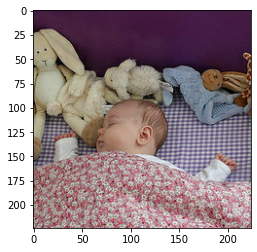

this is the image number: 0
the original class is: cradle
mobilenet_1.00_224 in format: False
prediction tf.Tensor(0.05432634, shape=(), dtype=float32)
loss_model tf.Tensor([0.00151727], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([0.35773912], shape=(1,), dtype=float32)
resnet50v2 in format: False
prediction tf.Tensor(0.27722195, shape=(), dtype=float32)
loss_model tf.Tensor([0.04500045], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([1.8569878], shape=(1,), dtype=float32)
vgg16 in format: False
prediction tf.Tensor(0.010017434, shape=(), dtype=float32)
loss_model tf.Tensor([5.0426996e-05], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([0.04031533], shape=(1,), dtype=float32)
vgg19 in format: False
prediction tf.Tensor(0.023714688, shape=(), dtype=float32)
loss_model tf.Tensor([0.00028458], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([0.09707054], shape=(1,), dtype=float32)
suma tf.Tensor([2.3989656], shap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


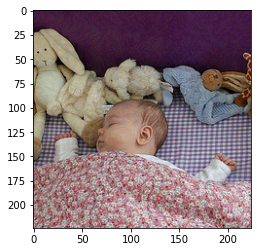

  0%|          | 1/5000 [04:33<380:26:27, 273.97s/it]

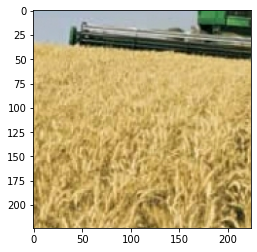

this is the image number: 1
the original class is: harvester
mobilenet_1.00_224 in format: False
prediction tf.Tensor(0.82005906, shape=(), dtype=float32)
loss_model tf.Tensor([0.7032523], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([5.2315893], shape=(1,), dtype=float32)
resnet50v2 in format: False
prediction tf.Tensor(0.89165145, shape=(), dtype=float32)
loss_model tf.Tensor([0.9908036], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([4.941368], shape=(1,), dtype=float32)
vgg16 in format: False
prediction tf.Tensor(0.0002709916, shape=(), dtype=float32)
loss_model tf.Tensor([3.6703124e-08], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([0.00104392], shape=(1,), dtype=float32)
vgg19 in format: False
prediction tf.Tensor(0.00014384885, shape=(), dtype=float32)
loss_model tf.Tensor([1.0336772e-08], shape=(1,), dtype=float32)
funcion de perdida auxiliar tf.Tensor([0.00055168], shape=(1,), dtype=float32)
suma tf.Tensor([11.868609],

KeyboardInterrupt: ignored

In [ ]:
#@title Core
from random import choice
import tqdm
from IPython.display import clear_output
from google.colab import files
i=0
experiments=[0.75,0.5,0.25,0.1,0.05,0.025,]
experiments_did=[0.75,0.5,0.25,0.1,0.05]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
sccLoss = tf.keras.losses.SparseCategoricalCrossentropy()
for pert_experiment in experiments:
  if pert_experiment in experiments_did:
    pass
  else:
    outpath=outpath_base+str(pert_experiment)
    filenamezip="adversarial"+str(pert_experiment)+".zip"
    !mkdir $outpath
    filenamelog='log_e_'+str(pert_experiment)+'.txt'
    filenamemodelused="models_used.txt"
    with open(filenamemodelused,"w") as f:
      for model in models_list_to_experiment:
        f.write(model.model_name+"\n")

    with open(filenamelog, 'w') as the_file:

      for original_images,preprocess_image,filepath in tqdm.tqdm(images_original): 
    
        isValidImage=True
        number_iteration=0
        plt.imshow(tf.cast(original_images[0],tf.int32))
        plt.show()
        print("this is the image number:",i)

        for model in models_list_to_experiment:
          model.is_next_iteracion_model_predicts_the_correct_class()

        filename=filepath.numpy()[0][-28:].decode()
        
        # original_nameclass,class_confidence_original_img_worse_model,original_idclass=data_from_original_image(filename,model_to_worse)

        original_nameclass,original_idclass=data_from_original_image(filename)
        prediction_original_nameclass,prediction_original_id_class,condifence_prediction_original=prediction_original(preprocess_image,model)
        any_class_except_classIdx=choice([i for i in range(0,999) if i not in [original_idclass]])

        delta = tf.Variable(tf.zeros_like(preprocess_image), trainable=True)

        
        baseImage_preprocess=tf.identity(preprocess_image)
        
        adversarial=baseImage_preprocess
        pert_max=pert_experiment #modificación maxima de los pixeles, como el valor esta normalizado a 1 esto siginifica que es el porcentaje que varia máximo de los pixeles
        # max_pert=adversarial+pert_max
        # min_pert=adversarial-pert_max
    
        print("the original class is:", original_nameclass)

        while is_necesary_continue_because_not_all_accuracy_are_achieve_for_the_purpose_of_the_model_in_this_image(models_list_to_experiment) and isValidImage:
          
          # delta=generate_adversarial_image(models_list_to_experiment,baseImage_preprocess,delta,original_idclass,any_class_except_classIdx)
          


          with tf.GradientTape() as tape:
            tape.watch(delta)
            for model in models_list_to_experiment:
              model.predict(adversarial+delta)
            if number_iteration%10==0:
              loss = function_loss(original_idclass, models_list_to_experiment,debug=True)
            else:
              loss = function_loss(original_idclass, models_list_to_experiment)
            
          if number_iteration%10==0:
            print(number_iteration)
            for model in models_list_to_experiment:
              model.update_accuracy_in_the_class_of_this_image(original_idclass)
              accuracy_to_model=model.accuracy_in_the_class_of_this_image
              is_target_hit=model.model_predicts_the_correct_class
              # model.continue_calculate_loss()
              
              print("accuracy to model {} in the original class: {:.4f}% the target in this image is hit {}".format(model.model_name,accuracy_to_model*100,is_target_hit))
        

          if number_iteration>=5000:
            clear_output()
            print("no convergia")
            print("this is the image number:",i)
            adversarial=tf.identity(preprocess_image)
            number_iteration=0
          elif number_iteration==1000:
            print("no converge a la 2000 iteración")

            isValidImage=False
            
          else:
          
            number_iteration+=1
            gradients = tape.gradient(loss, delta)
            # test=tf.identity(adversarial)
          
            # pattern=adversarial-test
            # adversarial-=gradients
            
            # adversarial=tf.clip_by_value(adversarial, clip_value_min=min_pert, clip_value_max=max_pert)
            # adversarial=tf.clip_by_value(adversarial, clip_value_min=-1, clip_value_max=1)        
            # delta=tf.clip_by_value(delta, clip_value_min=-1, clip_value_max=1)
            optimizer.apply_gradients([(gradients, delta)])
            delta.assign(tf.clip_by_value(delta, clip_value_min=-pert_experiment, clip_value_max=pert_experiment))

        hacked_image=tf.identity(adversarial+delta)
        hacked_image+=1
        hacked_image*=127.5

        pattern_image=original_images-hacked_image

        plt.imshow((tf.cast(hacked_image[0],tf.int32)))
        plt.show()
        new_filename=filename.split(".")[0]+".png"
        filepath=outpath+"/pert_eps_"+str(pert_max)+"_"+new_filename
        tf.keras.preprocessing.image.save_img(
              filepath, tf.cast(hacked_image[0],tf.int32).numpy(), data_format=None, file_format="PNG"
          )
        i+=1
        for model in models_list_to_experiment:

          if model.model_predicts_the_correct_class:
            target="hit"
          else:
            target="false"

          class_confidence_original_img=model.model(preprocess_image)[0][original_idclass].numpy()
          txto=(model.model_name+","+
                target+","+
                filename+","+
                original_nameclass+","+
                str(class_confidence_original_img)+","+

                str(prediction_original_nameclass)+","+
                str(prediction_original_id_class)   +","+
                str(condifence_prediction_original)+","+
                
                str(pert_max)+","+
                str(isValidImage)+","+
                str(model.accuracy_in_the_class_of_this_image)+","+
                
                'pert_eps_'+str(pert_max)+'_'+new_filename+"\n"
                )
          the_file.write(txto)
        #el asunto seguira el siguiente formato
        #modelo,objetivo en la iteracion,nombre de archivo,clase original(nombre), fiabilidad inicial,perturbacion,fiabilidad despues de perturbacion, nombre de la nueva imagen

        # print("cost worse model:",cost_to_worse, "lower better")
        # print("cost better model ",cost_to_better, "higher better")
        # original_nameclass,class_confidence_original_img_worse_model,original_idclass=data_from_original_image(filename,model_to_worse)
        # 
        # txto=(filename+","+original_nameclass+","+str(class_confidence_original_img)+","+str(pert_max)+","+adversarial_nameclass+","+str(cost)+ ',pert_eps_'+str(pert_max)+'_'+new_filename+"\n")   
        
        
        if i%2==0:
          clear_output()

    commandfolderextract=outpath+"/*"
    !zip $filenamezip $filenamemodelused $filenamelog $commandfolderextract
    
    files.download(filenamezip) 


In [ ]:
for model in models_list_to_experiment:
  print(model.prediction[0][original_idclass].numpy())

In [ ]:
 for model in models_list_to_experiment:
  print(model.accuracy_in_the_class_of_this_image)

In [ ]:
plt.imshow((tf.cast(hacked_image[0],tf.int32)))
predicts=model.predict(preproces_input(hacked_image))
print(decode_predictions(predicts))

In [ ]:
plt.imshow(tf.cast(original_images[0],tf.int32))
predicts=model_to_worse.predict(preproces_input(original_images))
print(decode_predictions(predicts))

In [ ]:
plt.imshow((tf.cast(preprocess_image[0],tf.int32)))
predicts=model_to_worse.predict(tf.keras.applications.resnet.preprocess_input(preprocess_image))
print(decode_predictions(predicts))